# Manually Constructing a TensorRT Engine

The Python API provides a path for Python-based frameworks, which might be unsupported by the UFF converter, if they use NumPy compatible layer weights. 

For this example, we will use PyTorch. 

First, we import TensorRT.

In [1]:
import tensorrt as trt

We use PyCUDA to transfer data to/from the GPU and NumPy to store data.

In [2]:
import pycuda.driver as cuda
import pycuda.autoinit
import numpy as np
from matplotlib.pyplot import imshow # to show test case

Then, we import PyTorch and its various packages.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

## Training a Model in PyTorch

For more detailed information about training models in PyTorch, see http://pytorch.org/tutorials/

First, we define hyper-parameters, then create a dataloader, define our network, set our optimizer and define our training and testing steps.

In [4]:
BATCH_SIZE = 64
TEST_BATCH_SIZE = 1000
EPOCHS = 3
LEARNING_RATE = 0.001
SGD_MOMENTUM = 0.5  
SEED = 1
LOG_INTERVAL = 100

In [5]:
# Enable Cuda
torch.cuda.manual_seed(SEED)

In [6]:
# Dataloader
kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader  = torch.utils.data.DataLoader(
    datasets.MNIST('/tmp/mnist/data', train=True, download=True, 
                    transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,))
        ])),
    batch_size=BATCH_SIZE,
    shuffle=True,
    **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/tmp/mnist/data', train=False, 
                   transform=transforms.Compose([
                   transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,))
        ])),
    batch_size=TEST_BATCH_SIZE,
    shuffle=True,
    **kwargs)

In [7]:
# Network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5)
        self.conv2 = nn.Conv2d(20, 50, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(800, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), kernel_size=2, stride=2)
        x = F.max_pool2d(self.conv2(x), kernel_size=2, stride=2)
        x = x.view(-1, 800)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = Net()
model.cuda()

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [8]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=SGD_MOMENTUM)

In [9]:
def train(epoch):
    model.train()
    for batch, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'
                  .format(epoch, 
                          batch * len(data), 
                          len(train_loader.dataset), 
                          100. * batch / len(train_loader), 
                          loss.data.item()))

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        with torch.no_grad():
            data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target).data.item()
        pred = output.data.max(1)[1]
        correct += pred.eq(target.data).cpu().sum()
    test_loss /= len(test_loader)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
          .format(test_loss, 
                  correct, 
                  len(test_loader.dataset), 
                  100. * correct / len(test_loader.dataset)))




Now we train the model.

In [10]:
for e in range(EPOCHS):
    train(e + 1)
    test(e + 1)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.332863
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.213236
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.050972
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.812923
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.430756
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.000302
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.681224
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.646954
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.690568
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.450487

Test set: Average loss: 0.4323, Accuracy: 8808/10000 (88%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.316998
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.490634
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.443835
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.397048
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.440638
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.259660
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.294566
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.488315
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.419440
T

## Converting the Model into a TensorRT Engine
Now that we have a "trained" model, we extract the layer wieghts by getting the `state_dict`

In [11]:
weights = model.state_dict()

Next, we create a builder and a logger for the build process.

In [12]:
G_LOGGER = trt.infer.ConsoleLogger(trt.infer.LogSeverity.ERROR)
builder = trt.infer.create_infer_builder(G_LOGGER)

Then, we replicate the network structure above in TensorRT and extract the weights from PyTorch in the form of numpy arrays. The numpy arrays from PyTorch reflect the dimensionality of the layers, so we flatten the arrays

In [13]:
network = builder.create_network()

# Name for the input layer, data type, tuple for dimension 
data = network.add_input("data", trt.infer.DataType.FLOAT, (1, 28, 28))
assert(data)

#-------------
conv1_w = weights['conv1.weight'].cpu().numpy().reshape(-1)
conv1_b = weights['conv1.bias'].cpu().numpy().reshape(-1)
conv1 = network.add_convolution(data, 20, (5,5),  conv1_w, conv1_b)
assert(conv1)
conv1.set_stride((1,1))

#-------------
pool1 = network.add_pooling(conv1.get_output(0), trt.infer.PoolingType.MAX, (2,2))
assert(pool1)
pool1.set_stride((2,2))

#-------------
conv2_w = weights['conv2.weight'].cpu().numpy().reshape(-1)
conv2_b = weights['conv2.bias'].cpu().numpy().reshape(-1)
conv2 = network.add_convolution(pool1.get_output(0), 50, (5,5), conv2_w, conv2_b)
assert(conv2)
conv2.set_stride((1,1))

#-------------
pool2 = network.add_pooling(conv2.get_output(0), trt.infer.PoolingType.MAX, (2,2))
assert(pool2)
pool2.set_stride((2,2))

#-------------
fc1_w = weights['fc1.weight'].cpu().numpy().reshape(-1)
fc1_b = weights['fc1.bias'].cpu().numpy().reshape(-1)
fc1 = network.add_fully_connected(pool2.get_output(0), 500, fc1_w, fc1_b)
assert(fc1)

#-------------
relu1 = network.add_activation(fc1.get_output(0), trt.infer.ActivationType.RELU)
assert(relu1)

#-------------
fc2_w = weights['fc2.weight'].cpu().numpy().reshape(-1)
fc2_b = weights['fc2.bias'].cpu().numpy().reshape(-1)
fc2 = network.add_fully_connected(relu1.get_output(0), 10, fc2_w, fc2_b)
assert(fc2)

Now, we need to mark our output layer.

In [14]:
fc2.get_output(0).set_name("prob")
network.mark_output(fc2.get_output(0))

We set the rest of the parameters for the network (max batch size and max workspace) and build the engine.

In [15]:
builder.set_max_batch_size(1)
builder.set_max_workspace_size(1 << 20)

engine = builder.build_cuda_engine(network)
network.destroy()
builder.destroy()

Now we create the engine runtime and generate a test case from the torch dataloader.

Test Case: 6


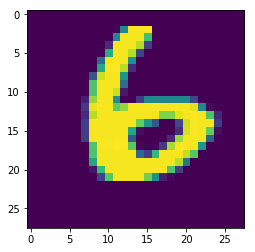

In [16]:
runtime = trt.infer.create_infer_runtime(G_LOGGER)
img, target = next(iter(test_loader))
img = img.numpy()[0]
target = target.numpy()[0]
%matplotlib inline
img.shape
imshow(img[0])
print("Test Case: " + str(target))
img = img.ravel()

Then, we create an execution context for the engine.

In [17]:
context = engine.create_execution_context()

Next, we allocate memory on the GPU, as well as on the host to hold results after inference. The size of these allocations is the size of the input/expected output * the batch size.

In [18]:
output = np.empty(10, dtype = np.float32)

# Allocate device memory
d_input = cuda.mem_alloc(1 * img.nbytes)
d_output = cuda.mem_alloc(1 * output.nbytes)

The engine requires bindings (pointers to GPU memory). PyCUDA lets us do this by casting the results of memory allocations to ints.

In [19]:
bindings = [int(d_input), int(d_output)] 

We create a cuda stream to run inference.

In [20]:
stream = cuda.Stream()

Now, we transfer the data to the GPU, run inference, then transfer the results to the host.

In [21]:
# Transfer input data to device
cuda.memcpy_htod_async(d_input, img, stream)
#execute model 
context.enqueue(1, bindings, stream.handle, None)
# Transfer predictions back
cuda.memcpy_dtoh_async(output, d_output, stream)
# Synchronize threads
stream.synchronize()

We can use `np.argmax` to get a prediction.

In [22]:
print("Test Case: " + str(target))
print ("Prediction: " + str(np.argmax(output)))

Test Case: 6
Prediction: 6


We can also save our engine to a file to use later.

In [23]:
trt.utils.write_engine_to_file("./pyt_mnist.engine", engine.serialize()) 

True

You can load this engine later by using `tensorrt.utils.load_engine`.

In [24]:
new_engine = trt.utils.load_engine(G_LOGGER, "./pyt_mnist.engine") 

Finally, we clean up our context, engine and runtime.

In [25]:
context.destroy()
engine.destroy()
new_engine.destroy()
runtime.destroy()